In [249]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epl-with-labels-matchday/EPL.csv
/kaggle/input/laliga-dataset-csv/all_laliga_matches_2014_2024.csv
/kaggle/input/epl-dataset-csv/EPL.csv
/kaggle/input/club-football-match-data-2000-2025/Matches.csv
/kaggle/input/club-football-match-data-2000-2025/EloRatings.csv
/kaggle/input/pl-dataframe/final_epl_fix.csv


# *DATA PREPROCESSING AND FEATURE ENGINEERING* 

In [250]:
def preprocess_data(path):
    """
    Preprocess the data by loading it from a CSV file, renaming columns, and converting data types.
    """
    df = pd.read_csv(path)
    df.sort_values(['date'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['result'] = pd.to_numeric(df['result'].replace({'w': 3, 'd': 1, 'l': 0}), errors='coerce')
    df['result'] = df['result'].fillna(0).round().astype(int)
    df.head(20)

    # Safe division function
    def safe_divide(a, b):
        return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

    # Create team views with safe calculations
    team_cols = ['date', 'team', 'team_form', 'xG', 'shots', 'shotOnTarget', 'deep', 'is_home', 'possession_proxy', 'final_pos']
    df['home_result'] = np.where(df['home_goals'] > df['away_goals'], 3,
                      np.where(df['home_goals'] == df['away_goals'], 1, 0))
    df['away_result'] = np.where(df['away_goals'] > df['home_goals'], 3,
                      np.where(df['away_goals'] == df['home_goals'], 1, 0))
    df_home = df.assign(
        team=df['home_team'],
        team_form=df['home_result'],
        is_home=1,
        final_pos= df['home_final_pos'],
        possession_proxy=(
            0.3 * safe_divide(df['xG_home'], df['xG_home']+df['xG_away']) +
            0.3 * safe_divide(df['home_shots'], df['home_shots']+df['away_shots']) +
            0.4 * safe_divide(df['home_deep'], df['home_deep']+df['away_deep'])
        )
    ).rename(columns={
        'xG_home': 'xG',
        'home_shots': 'shots',
        'home_shotOnTarget': 'shotOnTarget',
        'home_deep': 'deep'
    })[team_cols]

    df_away = df.assign(
        team=df['away_team'],
        team_form=df['away_result'],
        is_home=0,
        final_pos= df['away_final_pos'],
        possession_proxy=(
            0.3 * safe_divide(df['xG_away'], df['xG_home']+df['xG_away']) +
            0.3 * safe_divide(df['away_shots'], df['home_shots']+df['away_shots']) +
            0.4 * safe_divide(df['away_deep'], df['home_deep']+df['away_deep'])
        )
    ).rename(columns={
        'xG_away': 'xG',
        'away_shots': 'shots',
        'away_shotOnTarget': 'shotOnTarget',
        'away_deep': 'deep'
    })[team_cols]

    # Combine and sort
    df_team = pd.concat([df_home, df_away]).sort_values(['team','date']).reset_index(drop=True)

    # Calculate rolling features
    stats = ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']
    for stat in stats:
        df_team[f'rolling_{stat}'] = (
            df_team.groupby('team')[stat]
            .transform(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
            # Optional: fill initial NaN per team
            .fillna(0)
        )
    return df_team, df


In [251]:
team_df, match_df = preprocess_data('/kaggle/input/laliga-dataset-csv/all_laliga_matches_2014_2024.csv')
team_df.groupby('team', as_index=False).head(50)
# match_df.head(5)

/tmp/ipykernel_31/1896420408.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['result'] = pd.to_numeric(df['result'].replace({'w': 3, 'd': 1, 'l': 0}), errors='coerce')
/usr/local/lib/python3.11/dist-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


,date,team,team_form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,rolling_team_form,rolling_possession_proxy
0,2016-08-22,Alaves,1,0.033222,2,1,0,0,0.002366,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-08-28,Alaves,1,1.120170,13,2,2,1,0.240531,9,0.033222,2.000000,1.000000,0.000000,1.000000,0.002366
2,2016-09-10,Alaves,3,0.290172,5,4,0,0,0.053010,9,0.576696,7.500000,1.500000,1.000000,1.000000,0.121449
3,2016-09-19,Alaves,1,0.459330,9,1,5,1,0.121826,9,0.481188,6.666667,2.333333,0.666667,1.666667,0.098636
4,2016-09-23,Alaves,0,0.259625,8,1,2,0,0.046307,9,0.623224,9.000000,2.333333,2.333333,1.666667,0.138456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7911,2015-10-18,Villarreal,0,0.995361,12,3,4,1,0.113997,4,0.639816,5.666667,2.333333,3.666667,2.000000,0.126414
7912,2015-10-25,Villarreal,1,0.205133,5,0,2,0,0.156137,4,0.660415,6.666667,2.333333,3.333333,1.000000,0.112886
7913,2015-10-31,Villarreal,3,1.033370,11,5,10,1,0.161942,4,0.438428,6.666667,1.666667,2.333333,0.333333,0.099804
7914,2015-11-08,Villarreal,0,0.278588,5,2,1,0,0.024907,4,0.744621,9.333333,2.666667,5.333333,1.333333,0.144025


In [252]:
def merge(match_df, team_df):
    # print(team_df.columns.tolist())
    prepared_df = match_df.merge(
        team_df[team_df['is_home']==1][['date', 'team', *[f'rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]],
        left_on=['date', 'home_team'],
        right_on=['date', 'team'],
        suffixes=('', '_home')
    )
    prepared_df = prepared_df.merge(
        team_df[team_df['is_home']==0][['date', 'team', *[f'rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]],
        left_on=['date', 'away_team'],
        right_on=['date', 'team'],
        suffixes=('', '_away')
    )
    return prepared_df



In [253]:
prepared_df = merge(match_df, team_df)
prepared_df.head(10).filter(['team', 'date', 'xG', 'rolling_team_form', 'team_form', 'final_pos'])

,team,date,rolling_team_form
0,Sevilla,2014-08-23,0.0
1,Malaga,2014-08-23,0.0
2,Granada,2014-08-23,0.0
3,Almeria,2014-08-23,0.0
4,Barcelona,2014-08-24,0.0
5,Levante,2014-08-24,0.0
6,Celta Vigo,2014-08-24,0.0
7,Eibar,2014-08-24,0.0
8,Real Madrid,2014-08-25,0.0
9,Rayo Vallecano,2014-08-25,0.0


In [254]:
elo_df = pd.read_csv('/kaggle/input/club-football-match-data-2000-2025/EloRatings.csv')
elo_df['date'] = pd.to_datetime(elo_df['date'])  # Convert first if needed
elo_df[
    (elo_df['country'] == "ENG") & 
    (elo_df['date'].dt.year == 2020) & (elo_df['club'] == "Hull")
]


,date,club,country,elo
191341,2020-01-01,Hull,ENG,1517.40
191752,2020-01-15,Hull,ENG,1519.36
192158,2020-02-01,Hull,ENG,1501.64
192564,2020-02-15,Hull,ENG,1477.82
192970,2020-03-01,Hull,ENG,1447.64
193376,2020-03-15,Hull,ENG,1429.76
193782,2020-04-01,Hull,ENG,1429.76
194188,2020-04-15,Hull,ENG,1429.76
194594,2020-05-01,Hull,ENG,1429.76
195000,2020-05-15,Hull,ENG,1429.76


In [255]:
from scipy.special import expit as sigmoid

# Configuration
k = 400  # Elo rating scale factor
elo_baseline = 1500  # Baseline Elo rating
stats_cols = ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']
# 1. Prepare the base statistics (using year-specific means)
def get_year_specific_base_stats(year):
    year_mask = (team_df['date'].dt.year == year)
    return {
        'xG': team_df.loc[year_mask, 'rolling_xG'].mean(),
        'shots': team_df.loc[year_mask, 'rolling_shots'].mean(),
        'shotOnTarget': team_df.loc[year_mask, 'rolling_shotOnTarget'].mean(),
        'deep': team_df.loc[year_mask, 'rolling_deep'].mean(),
        'team_form': team_df.loc[year_mask, 'rolling_team_form'].mean(),
        'possession_proxy': team_df.loc[year_mask, 'rolling_possession_proxy'].mean()
    }

# 2. Define the imputation function
def elo_impute(base_stat, elo_team, k=400, elo_baseline=1500):
    return base_stat * (1 + sigmoid((elo_team - elo_baseline) / k))

# 3. Process each row that needs imputation
for idx, row in team_df.iterrows():
    if all(row[f'rolling_{col}'] == 0 for col in stats_cols):  # Check if any rolling stat is 0
        year = row['date'].year
        team = row['team']
        
        # Get year-specific base stats
        base_stats = get_year_specific_base_stats(year)
        
       # Find team's Elo rating (most recent before current date)
        filtered_elo = elo_df[
            (elo_df['club'] == team) & 
            (elo_df['date'] <= row['date'])
        ].sort_values('date', ascending=False)

        # Use baseline if no past Elo found
        team_elo = filtered_elo['elo'].values[0] if not filtered_elo.empty else elo_baseline
        
        # Impute each stat
        for stat in stats_cols:
            if row[f'rolling_{stat}'] == 0:
                base_stat = base_stats[stat]
                team_df.at[idx, f'rolling_{stat}'] = elo_impute(base_stat, team_elo, k, elo_baseline)

In [256]:
team_df[team_df['team'] == "Ipswich"].head(50)

,date,team,team_form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,rolling_team_form,rolling_possession_proxy


In [257]:
prepared_df = merge(match_df, team_df)
prepared_df.groupby('home_team').first().filter(['home_final_pos'])

,home_final_pos
home_team,
Alaves,9
Almeria,19
Athletic Club,7
Atletico Madrid,3
Barcelona,1
Cadiz,12
Celta Vigo,8
Cordoba,20
Deportivo La Coruna,17


In [258]:
#prepared_df = prepared_df.drop(['team_away', 'is_home'], axis=1)
prepared_df.columns


Index(['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'is_home',
       'xG_home', 'xG_away', 'home_shots', 'away_shots', 'home_shotOnTarget',
       'away_shotOnTarget', 'home_deep', 'away_deep', 'result',
       'home_final_pos', 'away_final_pos', 'home_result', 'away_result',
       'team', 'rolling_xG', 'rolling_shots', 'rolling_shotOnTarget',
       'rolling_deep', 'rolling_team_form', 'rolling_possession_proxy',
       'team_away', 'rolling_xG_away', 'rolling_shots_away',
       'rolling_shotOnTarget_away', 'rolling_deep_away',
       'rolling_team_form_away', 'rolling_possession_proxy_away'],
      dtype='object')

In [259]:
prepared_df.sort_values(by=['team', 'date']).head(20).filter(['date', 'home_team', 'away_team', 'team', 'home_result', 'away_result', 'home_final_pos', 'away_final_pos'])

,date,home_team,away_team,team,home_result,away_result,home_final_pos,away_final_pos
778,2016-08-28,Alaves,Sporting Gijon,Alaves,1,1,9,18
799,2016-09-19,Alaves,Deportivo La Coruna,Alaves,1,1,9,16
819,2016-09-26,Alaves,Granada,Alaves,3,0,9,20
838,2016-10-16,Alaves,Malaga,Alaves,1,1,9,11
852,2016-10-29,Alaves,Real Madrid,Alaves,0,3,9,1
875,2016-11-20,Alaves,Espanyol,Alaves,0,3,9,8
897,2016-12-04,Alaves,Las Palmas,Alaves,1,1,9,14
910,2016-12-16,Alaves,Real Betis,Alaves,3,0,9,15
943,2017-01-21,Alaves,Leganes,Alaves,1,1,9,17
952,2017-01-28,Alaves,Atletico Madrid,Alaves,1,1,9,3


In [260]:
team_df.sort_values(by=['team', 'date'])[team_df['team']=="Barcelona"].head(20)

,date,team,team_form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,rolling_team_form,rolling_possession_proxy
1242,2014-08-24,Barcelona,3,1.541240,12,6,12,1,0.680348,1,2.085044,19.607286,6.947733,7.776746,2.315911,0.306723
1243,2014-08-31,Barcelona,3,3.125450,20,8,11,0,0.221464,1,1.541240,12.000000,6.000000,12.000000,3.000000,0.680348
1244,2014-09-13,Barcelona,3,2.177200,14,8,14,1,0.287082,1,2.333345,16.000000,7.000000,11.500000,3.000000,0.450906
1245,2014-09-21,Barcelona,3,3.822900,17,8,14,0,0.668910,1,2.281297,15.333333,7.333333,12.333333,3.000000,0.396298
1246,2014-09-24,Barcelona,1,0.646364,10,0,7,0,0.209627,1,3.041850,17.000000,8.000000,13.000000,3.000000,0.392485
1247,2014-09-27,Barcelona,3,4.927580,19,12,16,1,0.675138,1,2.215488,13.666667,5.333333,11.666667,2.333333,0.388540
1248,2014-10-04,Barcelona,3,2.978340,18,7,12,0,0.255729,1,3.132281,15.333333,6.666667,12.333333,2.333333,0.517892
1249,2014-10-18,Barcelona,3,3.092940,27,12,19,1,0.630696,1,2.850761,15.666667,6.333333,11.666667,2.333333,0.380164
1250,2014-10-25,Barcelona,0,1.302810,15,5,7,0,0.122842,1,3.666287,21.333333,10.333333,15.666667,3.000000,0.520521
1251,2014-11-01,Barcelona,0,2.661590,19,9,16,1,0.189338,1,2.458030,20.000000,8.000000,12.666667,2.000000,0.336422


In [261]:
train1_df = team_df.merge(
    prepared_df[['date','home_team', 'away_team', 'xG_away', 'home_goals', 'away_goals', *[f'away_{stat}' for stat in ['shots', 'shotOnTarget', 'deep']], *[f'rolling_{stat}_away' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]], 
    left_on= ['date', 'team'],
    right_on = ['date', 'home_team'],
    how = 'left'
)
#train_df.head(10).filter(['date', 'team', 'away_team', 'rolling_xG_away'])
train1_df.columns
rename_dict = {
                'team_form': 'form',
               'away_team': 'opponent',
                'away_goals': 'goal_conceded',
                'home_goals': 'goal_scored',
               'xG_home': 'xG',
               'xG_away': 'opponent_xG',
               **{f'away_{stat}': f'opponent_{stat}' for stat in ['shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']},
               **{f'rolling_{stat}_away': f'opponent_rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']}}
train1_df = train1_df.rename(columns =rename_dict)
train1_df.drop(columns = ['home_team'])
train1_df.columns

Index(['date', 'team', 'form', 'xG', 'shots', 'shotOnTarget', 'deep',
       'is_home', 'possession_proxy', 'final_pos', 'rolling_xG',
       'rolling_shots', 'rolling_shotOnTarget', 'rolling_deep',
       'rolling_team_form', 'rolling_possession_proxy', 'home_team',
       'opponent', 'opponent_xG', 'goal_scored', 'goal_conceded',
       'opponent_shots', 'opponent_shotOnTarget', 'opponent_deep',
       'opponent_rolling_xG', 'opponent_rolling_shots',
       'opponent_rolling_shotOnTarget', 'opponent_rolling_deep',
       'opponent_rolling_team_form', 'opponent_rolling_possession_proxy'],
      dtype='object')

In [262]:
train1_df[train1_df['team']== 'Barcelona'].head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,...,goal_conceded,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy
1242,2014-08-24,Barcelona,3,1.541240,12,6,12,1,0.680348,1,...,0.0,3.0,0.0,0.0,1.927212,18.123069,6.421809,7.188067,2.140603,0.283505
1243,2014-08-31,Barcelona,3,3.125450,20,8,11,0,0.221464,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1244,2014-09-13,Barcelona,3,2.177200,14,8,14,1,0.287082,1,...,0.0,3.0,2.0,3.0,1.698860,11.000000,5.000000,4.500000,1.500000,0.200315
1245,2014-09-21,Barcelona,3,3.822900,17,8,14,0,0.668910,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1246,2014-09-24,Barcelona,1,0.646364,10,0,7,0,0.209627,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [263]:
train2_df = team_df.merge(
    prepared_df[['date','home_team', 'away_team', 'home_goals', 'away_goals', 'xG_home', *[f'home_{stat}' for stat in ['shots', 'shotOnTarget', 'deep']], *[f'rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]], 
    left_on= ['date', 'team'],
    right_on = ['date', 'away_team'],
    how = 'left',
    suffixes = ['','_home']
)
#train_df.head(10).filter(['date', 'team', 'away_team', 'rolling_xG_away'])
train2_df.columns
rename_dict = {
                'team_form': 'form',
               'home_team': 'opponent',
                'home_goals': 'goal_conceded',
                'away_goals': 'goal_scored',
               'xG_home': 'opponent_xG',
               **{f'home_{stat}': f'opponent_{stat}' for stat in ['shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']},
               **{f'rolling_{stat}_home': f'opponent_rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']}}
train2_df = train2_df.rename(columns =rename_dict)
train2_df.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,...,opponent_xG,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy
0,2016-08-22,Alaves,1,0.033222,2,1,0,0,0.002366,9,...,4.17855,27.0,6.0,9.0,1.340883,13.333333,5.333333,5.666667,2.0,0.192714
1,2016-08-28,Alaves,1,1.120170,13,2,2,1,0.240531,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-09-10,Alaves,3,0.290172,5,4,0,0,0.053010,9,...,1.35200,16.0,2.0,16.0,3.137880,18.000000,8.333333,20.333333,3.0,0.395491
3,2016-09-19,Alaves,1,0.459330,9,1,5,1,0.121826,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-09-23,Alaves,0,0.259625,8,1,2,0,0.046307,9,...,1.42235,12.0,2.0,7.0,1.799863,16.000000,5.000000,6.333333,0.0,0.161394


In [264]:
final_df = train1_df.copy()

# Fill in missing values in train1_df with values from train2_df
final_df = final_df.fillna(train2_df)

In [265]:
final_df.head().filter(['team', 'form', 'xG', 'goal_scored', 'goal_conceded', 'opponent_xG'])

,team,form,xG,goal_scored,goal_conceded,opponent_xG
0,Alaves,1,0.033222,1.0,1.0,4.178550
1,Alaves,1,1.120170,0.0,0.0,0.276950
2,Alaves,3,0.290172,2.0,1.0,1.352000
3,Alaves,1,0.459330,0.0,0.0,0.671784
4,Alaves,0,0.259625,1.0,2.0,1.422350


In [266]:
#arrangements according to the season instead of date.
final_df['date'] = pd.to_datetime(final_df['date'])
final_df['season'] = final_df['date'].apply(lambda x: x.year if x.month >= 8 else x.year-1)

final_df = final_df.sort_values(['season', 'team', 'date'])
grouped = final_df.groupby(['team', 'season'])

final_df[final_df['season']== 2021].head(20).filter(['date', 'season', 'team', 'final_pos'])

,date,season,team,final_pos
190,2021-08-14,2021,Alaves,20
191,2021-08-21,2021,Alaves,20
192,2021-08-27,2021,Alaves,20
193,2021-09-18,2021,Alaves,20
194,2021-09-22,2021,Alaves,20
195,2021-09-25,2021,Alaves,20
196,2021-10-01,2021,Alaves,20
197,2021-10-18,2021,Alaves,20
198,2021-10-23,2021,Alaves,20
199,2021-10-26,2021,Alaves,20


In [267]:
final_df = final_df.sort_values(["season", "team", "date"]).reset_index()

In [268]:
final_df.filter([
    'season',
    'team',
    'opponent',
    'final_pos'
]).groupby(
    'season'
).head(1)
final_df.head(5)
#final_df.columns

,index,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,...,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy,season
0,300,2014-08-23,Almeria,1,0.978788,19,6,5,1,0.213074,...,12.0,2.0,4.0,1.802489,16.950196,6.006208,6.722876,2.002069,0.265158,2014
1,301,2014-08-29,Almeria,0,1.310790,11,4,4,0,0.149603,...,12.0,3.0,3.0,0.673965,12.000000,3.000000,4.000000,0.000000,0.078030,2014
2,302,2014-09-12,Almeria,1,1.036280,12,2,5,1,0.172719,...,11.0,4.0,1.0,0.309957,7.000000,1.500000,3.000000,0.500000,0.092518,2014
3,303,2014-09-21,Almeria,3,0.603236,13,5,2,0,0.079283,...,22.0,6.0,12.0,1.672211,17.000000,4.666667,4.666667,1.333333,0.153204,2014
4,304,2014-09-24,Almeria,0,0.263228,6,1,1,1,0.040450,...,19.0,9.0,11.0,1.636893,13.666667,5.333333,4.333333,2.333333,0.175145,2014


In [269]:
final_df=final_df.drop(columns=['home_team'])

In [270]:
final_df.head(5)


,index,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,...,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy,season
0,300,2014-08-23,Almeria,1,0.978788,19,6,5,1,0.213074,...,12.0,2.0,4.0,1.802489,16.950196,6.006208,6.722876,2.002069,0.265158,2014
1,301,2014-08-29,Almeria,0,1.310790,11,4,4,0,0.149603,...,12.0,3.0,3.0,0.673965,12.000000,3.000000,4.000000,0.000000,0.078030,2014
2,302,2014-09-12,Almeria,1,1.036280,12,2,5,1,0.172719,...,11.0,4.0,1.0,0.309957,7.000000,1.500000,3.000000,0.500000,0.092518,2014
3,303,2014-09-21,Almeria,3,0.603236,13,5,2,0,0.079283,...,22.0,6.0,12.0,1.672211,17.000000,4.666667,4.666667,1.333333,0.153204,2014
4,304,2014-09-24,Almeria,0,0.263228,6,1,1,1,0.040450,...,19.0,9.0,11.0,1.636893,13.666667,5.333333,4.333333,2.333333,0.175145,2014


# FEATURE ENGINEERING

In [271]:
final_df['shot_accuracy'] = final_df['shotOnTarget']/(final_df['shots'] + 1e-5)
final_df['rolling_shot_accuracy'] = final_df['rolling_shotOnTarget']/(final_df['rolling_shots'] + 1e-5)
final_df['opponent_shot_accuracy'] = final_df['opponent_shotOnTarget']/(final_df['opponent_shots']+ 1e-5)
final_df['opponent_rolling_shot_accuracy'] = final_df['opponent_rolling_shotOnTarget']/(final_df['opponent_rolling_shots']+ 1e-5)
final_df['total_goal_scored'] = final_df.groupby(['team', 'season'])["goal_scored"].cumsum()
final_df['total_goal_conceded'] = final_df.groupby(['team', 'season'])["goal_conceded"].cumsum()
final_df['gD'] = final_df['total_goal_scored'] - final_df['total_goal_conceded']
final_df['total_points'] = final_df.groupby(['team', 'season'])['form'].cumsum()
season_teams = final_df.groupby('season')['team'].unique().to_dict()
final_df['is_newly_promoted'] = 0
for idx, row in final_df.iterrows():
    current_season = row['season']
    team = row['team']
    if current_season == final_df['season'].min():
        continue
    previous_season = current_season - 1
    if previous_season in season_teams:
        if team not in season_teams[previous_season]:
            final_df.at[idx, 'is_newly_promoted'] = 1


final_df = final_df.drop(columns = ['shots', 'shotOnTarget','opponent_shotOnTarget', 'opponent_shots', 'rolling_shots', 'rolling_shotOnTarget', 'opponent_rolling_shots', 'opponent_rolling_shotOnTarget', 'possession_proxy', 'rolling_possession_proxy', 'opponent_rolling_possession_proxy'])
print(final_df.columns)
final_df.filter(['team', 'date', 'season', 'xG', 'form', 'rolling_team_form', 'opponent', 'opponent_xG', 'goal_scored', 'shot_accuracy', 'opponent_shot_accuracy', 'opponent_rolling_xG', 'opponent_rolling_team_form', 'rolling_shot_accuracy', 'opponent_rolling_shot_accuracy','goal_conceded', 'gD', 'is_newly_promoted', 'total_points'])[final_df['team']=="Barcelona"].head(40).sort_values(by=['season','team','date'])



Index(['index', 'date', 'team', 'form', 'xG', 'deep', 'is_home', 'final_pos',
       'rolling_xG', 'rolling_deep', 'rolling_team_form', 'opponent',
       'opponent_xG', 'goal_scored', 'goal_conceded', 'opponent_deep',
       'opponent_rolling_xG', 'opponent_rolling_deep',
       'opponent_rolling_team_form', 'season', 'shot_accuracy',
       'rolling_shot_accuracy', 'opponent_shot_accuracy',
       'opponent_rolling_shot_accuracy', 'total_goal_scored',
       'total_goal_conceded', 'gD', 'total_points', 'is_newly_promoted'],
      dtype='object')


,team,date,season,xG,form,rolling_team_form,opponent,opponent_xG,goal_scored,shot_accuracy,opponent_shot_accuracy,opponent_rolling_xG,opponent_rolling_team_form,rolling_shot_accuracy,opponent_rolling_shot_accuracy,goal_conceded,gD,is_newly_promoted,total_points
114,Barcelona,2014-08-24,2014,1.541240,3,2.315911,Elche,0.108040,3.0,0.500000,0.000000,1.927212,2.140603,0.354344,0.354344,0.0,3.0,0,3
115,Barcelona,2014-08-31,2014,3.125450,3,3.000000,Villarreal,1.108360,1.0,0.400000,0.000000,3.014120,3.000000,0.500000,0.500000,0.0,4.0,0,6
116,Barcelona,2014-09-13,2014,2.177200,3,3.000000,Athletic Club,0.097971,2.0,0.571428,0.666664,1.698860,1.500000,0.437500,0.454545,0.0,6.0,0,9
117,Barcelona,2014-09-21,2014,3.822900,3,3.000000,Levante,0.441980,5.0,0.470588,0.222222,0.345067,0.333333,0.478261,0.137931,0.0,11.0,0,12
118,Barcelona,2014-09-24,2014,0.646364,1,3.000000,Malaga,0.278657,0.0,0.000000,0.333333,0.799344,0.666667,0.470588,0.318182,0.0,11.0,0,13
119,Barcelona,2014-09-27,2014,4.927580,3,2.333333,Granada,0.445275,6.0,0.631579,0.111111,0.481294,1.333333,0.390244,0.263157,0.0,17.0,0,16
120,Barcelona,2014-10-04,2014,2.978340,3,2.333333,Rayo Vallecano,0.515599,2.0,0.388889,0.285714,1.992753,2.000000,0.434782,0.342105,0.0,19.0,0,19
121,Barcelona,2014-10-18,2014,3.092940,3,2.333333,Eibar,0.929153,3.0,0.444444,0.499999,0.783717,1.000000,0.404255,0.354838,0.0,22.0,0,22
122,Barcelona,2014-10-25,2014,1.302810,0,3.000000,Real Madrid,1.878870,1.0,0.333333,0.333333,2.955685,3.000000,0.484375,0.549019,3.0,20.0,0,22
123,Barcelona,2014-11-01,2014,2.661590,0,2.000000,Celta Vigo,1.555620,0.0,0.473684,0.400000,1.093238,1.333333,0.400000,0.303030,1.0,19.0,0,22


In [272]:
# final_df.to_csv('final_epl_fix.csv')

In [273]:
# #Save the dataframe to csv
# final_df.to_csv('/kaggle/working/final_df_prem.csv')
pl_df = pd.read_csv('/kaggle/input/pl-dataframe/final_epl_fix.csv', parse_dates=['date'])
pl_df['league_id'] = 0
final_df['league_id'] = 1
final_df = pd.concat([final_df, pl_df], ignore_index=True)

In [274]:
final_df= final_df.iloc[:, :-1]


In [275]:
final_df.to_csv('/kaggle/working/final_csv.csv')

In [276]:
final_df = final_df.sort_values(by=['league_id', 'team', 'season',  'date'])
final_df.filter([
    'team', 'form', 'rolling_team_form', 'opponent_rolling_deep'
]).head(6)
# print(final_df.columns)

,team,form,rolling_team_form,opponent_rolling_deep
8280,Arsenal,3,2.214947,9.347557
8281,Arsenal,1,3.000000,15.000000
8282,Arsenal,1,2.000000,1.000000
8283,Arsenal,1,1.666667,13.000000
8284,Arsenal,3,1.000000,3.666667
8285,Arsenal,1,1.666667,4.666667


In [277]:
# final_df = final_df.groupby(['team', 'season']).apply(lambda x: x.iloc[1:]).reset_index(drop=True)

In [278]:
!pip install scikit-learn
# !pip install --upgrade tensorflow

In [279]:
final_df.sort_values(['season', 'team', 'date', 'league_id']).filter(['team', 'season', 'date','form', 'xG', 'shot_accuracy', 'deep', 'is_home', 
        'rolling_team_form','rolling_xG', 'rolling_shot_accuracy', 'rolling_deep', 
        'opponent_xG', 'opponent_shot_accuracy',
       'opponent_deep', 'opponent_rolling_team_form', 'opponent_rolling_xG',
       'opponent_rolling_shot_accuracy',
       'opponent_rolling_deep'])[(final_df['season'] == 2024) & (final_df['league_id']==0) & (final_df['team']=="Liverpool")].head(40)
final_df.columns

/tmp/ipykernel_31/2346269437.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df.sort_values(['season', 'team', 'date', 'league_id']).filter(['team', 'season', 'date','form', 'xG', 'shot_accuracy', 'deep', 'is_home',


Index(['index', 'date', 'team', 'form', 'xG', 'deep', 'is_home', 'final_pos',
       'rolling_xG', 'rolling_deep', 'rolling_team_form', 'opponent',
       'opponent_xG', 'goal_scored', 'goal_conceded', 'opponent_deep',
       'opponent_rolling_xG', 'opponent_rolling_deep',
       'opponent_rolling_team_form', 'season', 'shot_accuracy',
       'rolling_shot_accuracy', 'opponent_shot_accuracy',
       'opponent_rolling_shot_accuracy', 'total_goal_scored',
       'total_goal_conceded', 'gD', 'total_points', 'is_newly_promoted',
       'league_id'],
      dtype='object')

In [280]:
final_df['opponent_code']  = final_df['opponent'].astype('category').cat.codes

In [281]:
final_df = final_df.sort_values(by=["season", "team", "date"])

# Create matchweek column: it resets for each season and starts from 1
final_df["matchweek"] = final_df.groupby(["season", "team"]).cumcount() + 1

In [282]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
scale_features = [
       'xG', 'shot_accuracy', 'deep',
       'rolling_team_form', 'rolling_xG',  'rolling_deep',  
       'opponent_xG',  'opponent_deep',
       'opponent_rolling_team_form', 'opponent_rolling_xG',
        'opponent_rolling_deep', 'gD', 'total_goal_scored', 'total_goal_conceded', 'opponent_code','total_points', 'matchweek' 
]
#encoding certain categorical features
# final_df['final_pos'] = final_df['final_pos'] - 1
final_df['deep'] = final_df['deep'].astype(int)
final_df['form'] = final_df['form'].replace({3: 2})



# Training set: 2014-2020 (7 seasons)
train_df = final_df[final_df["season"].isin(range(2014, 2022))].sort_values(['league_id', 'team', 'season'])  # 2014 to 2020 inclusive

# Validation set: 2021 (1 season) - For hyperparameter tuning
val_df = final_df[final_df["season"] == 2022].sort_values(['league_id', 'team', 'season'])

# Test set: 2022 (most recent season) - Final evaluation
test_df = final_df[final_df["season"] == 2023].sort_values(['league_id', 'team', 'season'])

train_df.to_csv('/kaggle/working/train_df.csv')
print(train_df.shape)
scaler = MinMaxScaler()
# 1. Fit and transform TRAIN data
scaled_train = scaler.fit_transform(train_df[scale_features])
final_train_df = pd.concat([
    pd.DataFrame(scaled_train, columns=scale_features, index=train_df.index),
    train_df[['form','shot_accuracy','rolling_shot_accuracy', 'opponent_shot_accuracy','opponent_rolling_shot_accuracy','is_home', 'is_newly_promoted', 'date', 'season', 'team', 'opponent', 'league_id']]
], axis=1)

# 2. Transform VALIDATION data
scaled_val = scaler.transform(val_df[scale_features])
final_val_df = pd.concat([
    pd.DataFrame(scaled_val, columns=scale_features, index=val_df.index),
    val_df[['form', 'shot_accuracy', 'rolling_shot_accuracy','opponent_shot_accuracy','opponent_rolling_shot_accuracy','is_home', 'is_newly_promoted', 'date', 'season', 'team', 'opponent', 'league_id']]
], axis=1)

# 3. Transform TEST data
scaled_test = scaler.transform(test_df[scale_features])
final_test_df = pd.concat([
    pd.DataFrame(scaled_test, columns=scale_features, index=test_df.index),
    test_df[['form', 'shot_accuracy','rolling_shot_accuracy','opponent_shot_accuracy','opponent_rolling_shot_accuracy','is_home', 'is_newly_promoted', 'date', 'season', 'team', 'opponent', 'league_id']]
], axis=1)

final_train_df['is_home'] = final_train_df['is_home'].astype(float)
final_train_df['is_newly_promoted'] = final_train_df['is_newly_promoted'].astype(float)
final_train_df['league_id'] = final_train_df['league_id'].astype(float)

final_val_df['is_home'] = final_val_df['is_home'].astype(float)
final_val_df['is_newly_promoted'] = final_val_df['is_newly_promoted'].astype(float)
final_val_df['league_id'] = final_val_df['league_id'].astype(float)

final_test_df['is_home'] = final_test_df['is_home'].astype(float)
final_test_df['is_newly_promoted'] = final_test_df['is_newly_promoted'].astype(float)
final_test_df['league_id'] = final_test_df['league_id'].astype(float)
final_val_df.dtypes
final_train_df['form'].value_counts()

(12160, 32)


form
2    4570
0    4570
1    3020
Name: count, dtype: int64

In [283]:

final_val_df.groupby(['team', 'season']).size()
final_train_df.head(19)

,xG,shot_accuracy,deep,rolling_team_form,rolling_xG,rolling_deep,opponent_xG,opponent_deep,opponent_rolling_team_form,opponent_rolling_xG,...,rolling_shot_accuracy,opponent_shot_accuracy,opponent_rolling_shot_accuracy,is_home,is_newly_promoted,date,season,team,opponent,league_id
8280,0.234388,0.428572,0.214286,0.738316,0.374432,0.393637,0.023852,0.000000,0.692072,0.350613,...,0.315151,0.499999,0.315151,1.0,0.0,2014-08-16,2014,Arsenal,Crystal Palace,0.0
8281,0.216206,0.230769,0.190476,1.000000,0.288259,0.355263,0.201236,0.071429,0.333333,0.110207,...,0.428571,0.250000,0.230769,0.0,0.0,2014-08-23,2014,Arsenal,Everton,0.0
8282,0.346353,0.250000,0.309524,0.666667,0.276851,0.335526,0.122124,0.095238,0.166667,0.167232,...,0.333333,0.333333,0.411764,0.0,0.0,2014-08-31,2014,Arsenal,Leicester,0.0
8283,0.313407,0.400000,0.214286,0.555556,0.327485,0.394737,0.348140,0.380952,0.666667,0.226672,...,0.294117,0.533333,0.289473,1.0,0.0,2014-09-13,2014,Arsenal,Manchester City,0.0
8284,0.205451,0.333333,0.166667,0.333333,0.360536,0.394737,0.097883,0.000000,0.777778,0.110755,...,0.288461,0.333333,0.192307,0.0,0.0,2014-09-20,2014,Arsenal,Aston Villa,0.0
8285,0.190740,0.375000,0.238095,0.555556,0.356037,0.381579,0.101581,0.095238,0.111111,0.180963,...,0.312500,0.666666,0.266666,1.0,0.0,2014-09-27,2014,Arsenal,Tottenham,0.0
8286,0.049875,0.000000,0.142857,0.555556,0.290949,0.342105,0.211542,0.071429,0.777778,0.481708,...,0.375000,0.599999,0.358490,0.0,0.0,2014-10-05,2014,Arsenal,Chelsea,0.0
8287,0.324026,0.360000,0.404762,0.444444,0.180722,0.302632,0.083261,0.000000,0.444444,0.186556,...,0.257143,0.999998,0.285714,1.0,0.0,2014-10-18,2014,Arsenal,Hull,0.0
8288,0.221825,0.333334,0.238095,0.222222,0.230318,0.434211,0.066585,0.142857,0.444444,0.229050,...,0.294117,0.272727,0.194444,0.0,0.0,2014-10-25,2014,Arsenal,Sunderland,0.0
8289,0.653014,0.375000,0.452381,0.444444,0.243320,0.434211,0.103199,0.047619,0.111111,0.262714,...,0.280000,0.333333,0.243902,1.0,0.0,2014-11-01,2014,Arsenal,Burnley,0.0


In [284]:
from tensorflow.keras.utils import to_categorical
feature_cols = [
        'xG', 'shot_accuracy', 'deep', 'is_home', 
        'rolling_team_form','rolling_xG', 'rolling_shot_accuracy', 'rolling_deep', 
        'opponent_xG', 'opponent_shot_accuracy',
       'opponent_deep', 'opponent_rolling_team_form', 'opponent_rolling_xG',
       'opponent_rolling_shot_accuracy', 'gD', 
       'opponent_rolling_deep', 'is_newly_promoted', 'matchweek', 'league_id'
]
def create_sequences(data, window_size = 5):
    sequences, targets = [], []
    grouped = data.groupby(['league_id', 'team', 'season' ])
    for (league_id, team, season), group in grouped:
        group = group.sort_values('date')
        if len(group) < (window_size + 1):
            continue
        X = group[feature_cols].values # it includes array 2-d (34, 23)
        # Convert `form` labels to one-hot
        y = group['form'].values
        y_onehot = to_categorical(y, num_classes=3)
        # print(y)
        for i in range(len(X) - window_size):
            sequences.append(X[i:i+window_size])
            targets.append(y_onehot[i+window_size])
    return np.array(sequences), np.array(targets)

In [285]:
categorical_cols = ['league_id', 'is_home', 'is_newly_promoted']
continuous_cols = [col for col in feature_cols if col not in categorical_cols]

# def create_sequences_with_embeddings(data, window_size=10):
#     sequences_cat, sequences_cont, targets = [], [], []
#     grouped = data.groupby(['league_id', 'team', 'season'])
#     for (league_id, team, season), group in grouped:
#         group = group.sort_values('date')
#         if len(group) < (window_size + 1):
#             continue
#         X_cat = group[categorical_cols].values
#         X_cont = group[continuous_cols].values
#         y = group['form'].values[window_size:]
#         y_mapped = np.where(y == 3, 2, y)
#         y_onehot = to_categorical(y_mapped, num_classes=3)

#         for i in range(len(group) - window_size):
#             sequences_cat.append(X_cat[i:i+window_size])
#             sequences_cont.append(X_cont[i:i+window_size])
#             targets.append(y_onehot[i])
#     return [np.array(sequences_cat), np.array(sequences_cont)], np.array(targets)


In [286]:
# Generate train/test sequences
X_train, y_train = create_sequences(final_train_df)
X_val, y_val = create_sequences(final_val_df)
X_test, y_test = create_sequences(final_test_df)


In [287]:
# Check feature ranges
print("Feature ranges (min, max):")
for i in range(X_train.shape[2]):
    print(f"Feature {i}: {X_train[:, :, i].min()}, {X_train[:, :, i].max()}")

# Check target ranges
print("Target range:", y_train.min(), y_train.max())

Feature ranges (min, max):
Feature 0: 0.0, 1.0
Feature 1: 0.0, 1.0
Feature 2: 0.0, 0.9999985714306124
Feature 3: 0.0, 1.0
Feature 4: 0.0, 1.0
Feature 5: 0.0, 1.0
Feature 6: 0.0, 1.0000000000000002
Feature 7: 0.0, 0.8333312500052085
Feature 8: 0.0, 0.9999999999999999
Feature 9: 0.0, 1.0
Feature 10: 0.0, 0.9999985714306124
Feature 11: 0.0, 1.0
Feature 12: 0.0, 1.0
Feature 13: 0.0, 1.0000000000000002
Feature 14: 0.0, 0.8333312500052085
Feature 15: 0.033333333333333326, 1.0
Feature 16: 0.0, 0.9999999999999999
Feature 17: 0.0, 1.0
Feature 18: 0.0, 0.972972972972973
Feature 19: 0.0, 1.0
Target range: 0.0 1.0


In [288]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns


***DATA VISUALIZATION FOR SEQUENCES / TEMPORAL PATTERN***


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

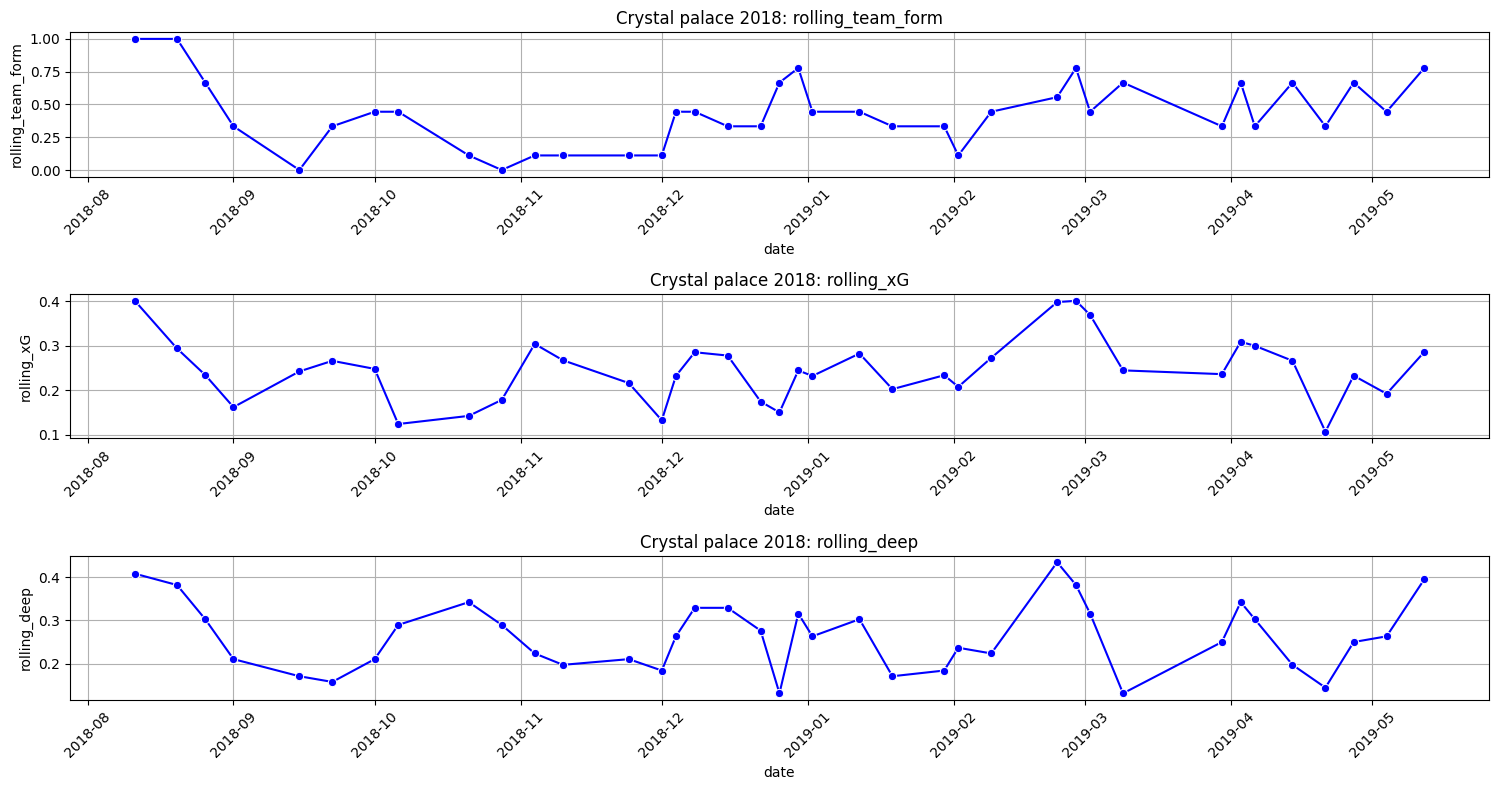

In [289]:

team_data = final_train_df[(final_train_df['team']== "Crystal Palace") & (final_train_df['season']== 2018)].sort_values(by='date')

plt.figure(figsize=(15, 8))  # Single figure with subplots

for i, feature in enumerate(['rolling_team_form', 'rolling_xG', 'rolling_deep'], 1):
    plt.subplot(3, 1, i)  # 3 rows, 1 column, position i
    sns.lineplot(data=team_data, x='date', y=feature, marker='o', color='blue')
    plt.title(f"Crystal palace 2018: {feature}")
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()  # Prevent overlapping labels
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

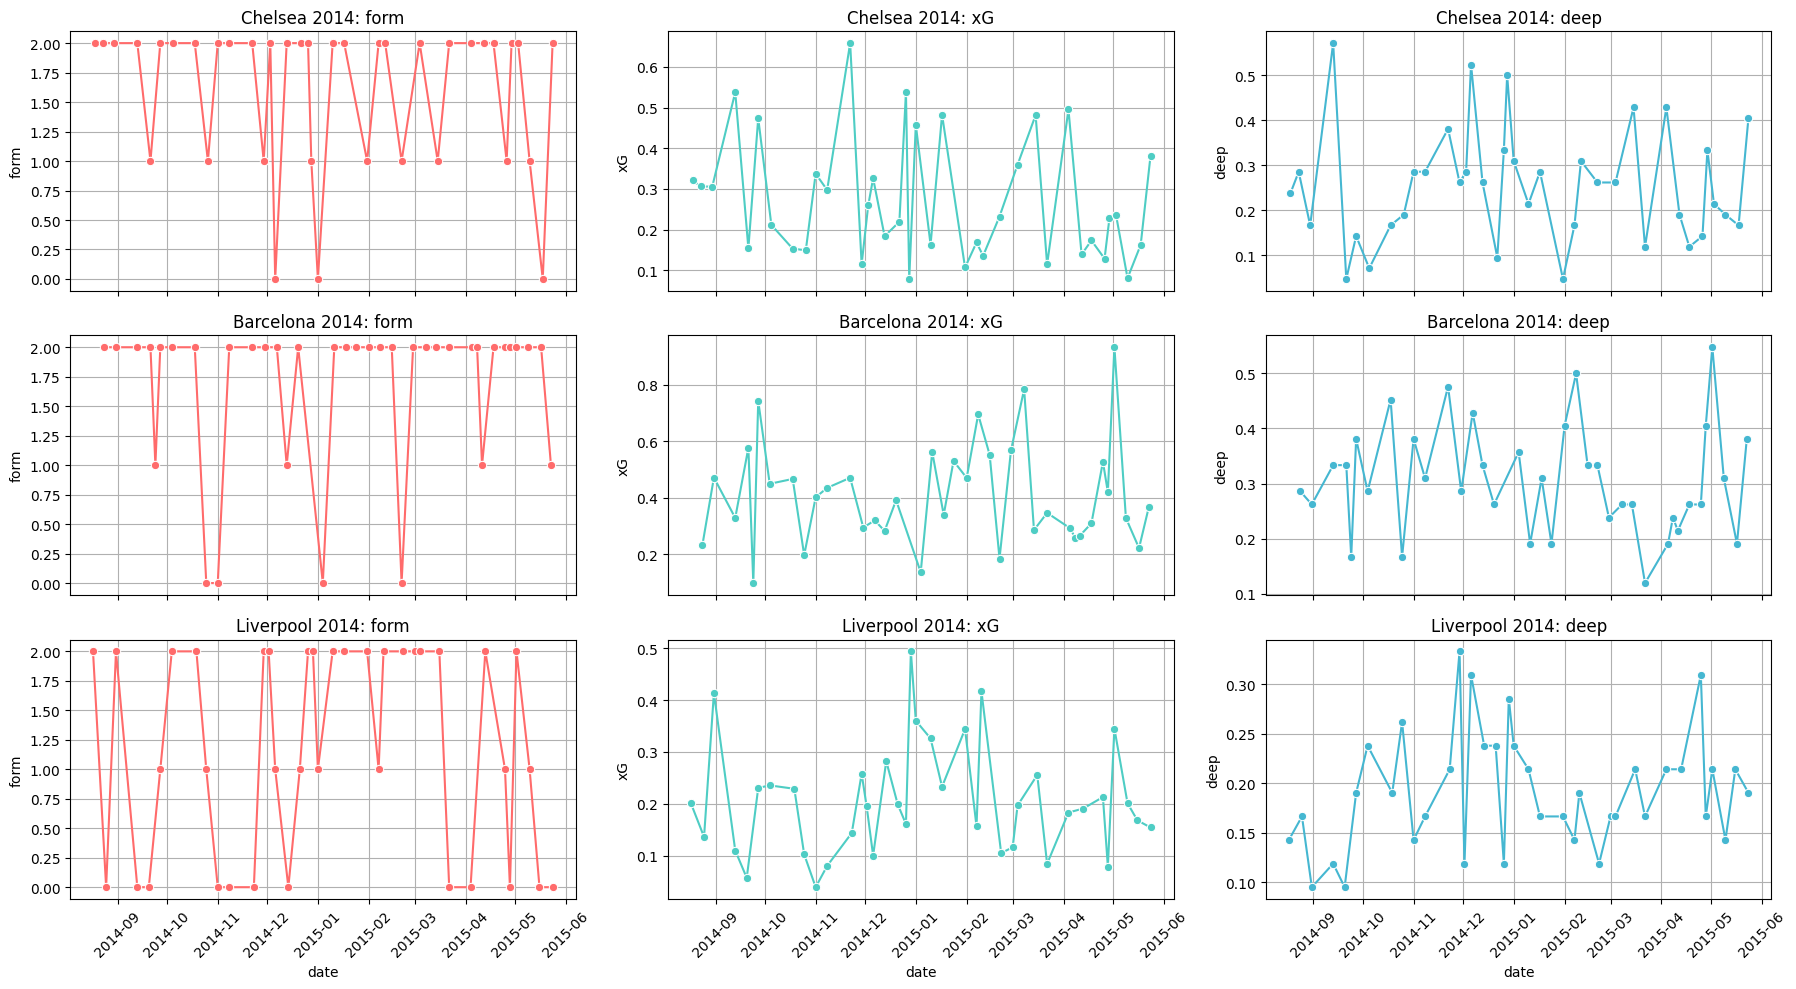

Infinite values in numeric columns:
xG                                0
shot_accuracy                     0
shot_accuracy                     0
deep                              0
rolling_team_form                 0
rolling_xG                        0
rolling_deep                      0
opponent_xG                       0
opponent_deep                     0
opponent_rolling_team_form        0
opponent_rolling_xG               0
opponent_rolling_deep             0
gD                                0
total_goal_scored                 0
total_goal_conceded               0
opponent_code                     0
total_points                      0
matchweek                         0
form                              0
shot_accuracy                     0
shot_accuracy                     0
rolling_shot_accuracy             0
opponent_shot_accuracy            0
opponent_rolling_shot_accuracy    0
is_home                           0
is_newly_promoted                 0
season                      

In [290]:

# Define teams and features to compare
teams = ["Chelsea", "Barcelona", "Liverpool"]  # Add more teams if needed
features = ['form', 'xG', 'deep']
season = 2014

# Set up subplots: 1 row per team, 3 columns per feature
fig, axes = plt.subplots(len(teams), len(features), figsize=(18, 10), sharex=True)

for i, team in enumerate(teams):
    # Filter team data for the season
    team_data = final_train_df[
        (final_train_df['team'] == team) & 
        (final_train_df['season'] == season)
    ].sort_values(by='date')
    
    for j, feature in enumerate(features):
        ax = axes[i, j]
        sns.lineplot(
            data=team_data, 
            x='date', 
            y=feature, 
            ax=ax,
            marker='o',
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'][j]  # Different colors per feature
        )
        ax.set_title(f"{team} {season}: {feature}")
        ax.set_ylabel(feature)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

plt.tight_layout()
plt.show()

# Check for infinite values (unchanged from your code)
numeric_cols = final_train_df.select_dtypes(include=[np.number]).columns
inf_counts = (np.isinf(final_train_df[numeric_cols])).sum()
print("Infinite values in numeric columns:")
print(inf_counts)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

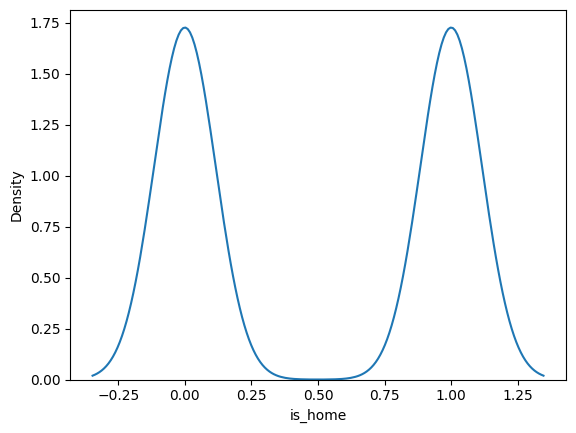

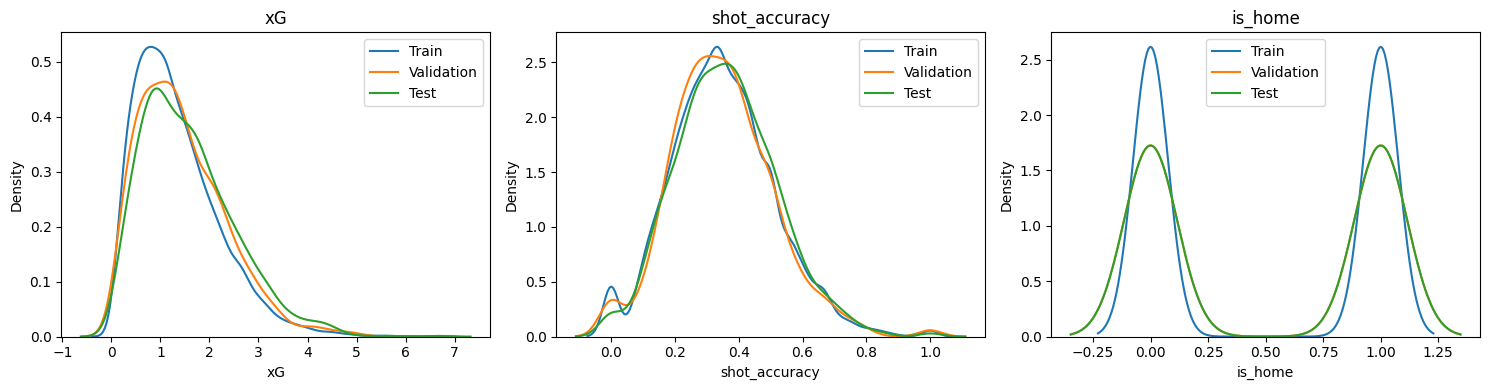

In [291]:
def plot_feature_distributions(features=['xG', 'shot_accuracy', 'is_home']):
    """Compare feature distributions across train/val/test sets"""
    plt.figure(figsize=(15, 4))
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i+1)
        sns.kdeplot(train_df[feature], label='Train')
        sns.kdeplot(val_df[feature], label='Validation')
        sns.kdeplot(test_df[feature], label='Test')
        plt.title(feature)
        plt.legend()
    plt.tight_layout()
    plt.show()
sns.kdeplot(val_df['is_home'], label='Validation')
plot_feature_distributions()

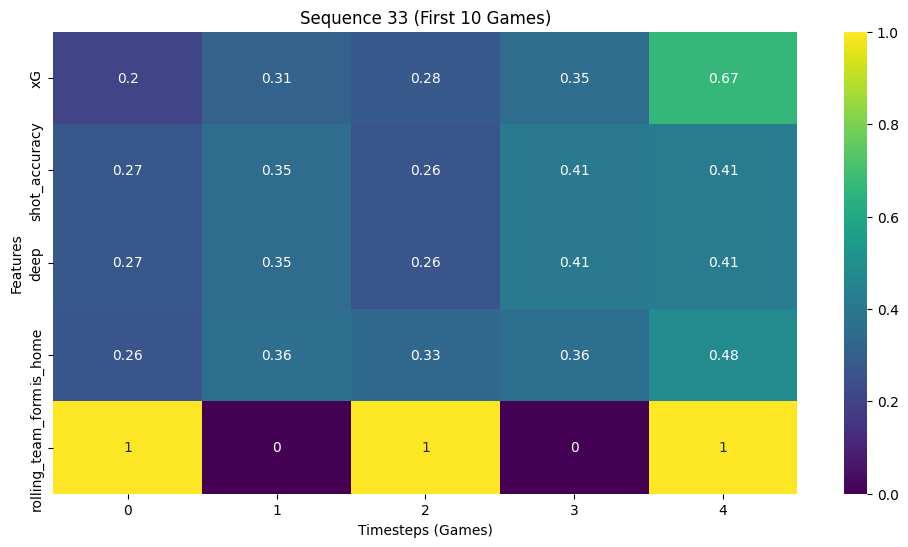

In [292]:
def plot_sequence(sequence_idx, max_timesteps=10, n_features=5):
    """Plot first N timesteps of a sample sequence"""
    plt.figure(figsize=(12, 6))
    
    # Get first sequence (padded)
    sample_seq = X_train[sequence_idx][:max_timesteps, :n_features]
    
    # Create heatmap
    sns.heatmap(sample_seq.T, annot=True, cmap='viridis', 
                yticklabels=feature_cols[:n_features])
    plt.title(f"Sequence {sequence_idx} (First {max_timesteps} Games)")
    plt.xlabel("Timesteps (Games)")
    plt.ylabel("Features")
    plt.show()

# Example: First sequence, first 5 features
plot_sequence(33, max_timesteps=10, n_features=5)

In [293]:
# print("Training mean:", scaler.mean_[:5])  # First 5 features' means
# print("Training std:", scaler.scale_[:5])  # First 5 features' std devs

# # Check test data didn't influence scaling
# assert np.allclose(scaler.mean_, train_df[scale_features].mean()), "Data leakage!"

In [294]:
# plt.figure(figsize=(10, 4))
# sns.countplot(x=y_train)
# plt.title("Distribution of Final Positions (Training Set)")
# plt.show()

In [295]:
X_train.shape
X_train

array([[[0.23438841, 0.42857173, 0.42857112, ..., 0.        ,
         0.        , 0.        ],
        [0.21620574, 0.23076938, 0.23076905, ..., 0.        ,
         0.02702703, 0.        ],
        [0.34635298, 0.25000025, 0.2499999 , ..., 0.        ,
         0.05405405, 0.        ],
        [0.3134067 , 0.4000003 , 0.39999973, ..., 0.        ,
         0.08108108, 0.        ],
        [0.20545088, 0.33333344, 0.33333296, ..., 0.        ,
         0.10810811, 0.        ]],

       [[0.21620574, 0.23076938, 0.23076905, ..., 0.        ,
         0.02702703, 0.        ],
        [0.34635298, 0.25000025, 0.2499999 , ..., 0.        ,
         0.05405405, 0.        ],
        [0.3134067 , 0.4000003 , 0.39999973, ..., 0.        ,
         0.08108108, 0.        ],
        [0.20545088, 0.33333344, 0.33333296, ..., 0.        ,
         0.10810811, 0.        ],
        [0.19074005, 0.3750003 , 0.37499977, ..., 0.        ,
         0.13513514, 0.        ]],

       [[0.34635298, 0.25000025, 0.2

In [296]:
print("y_train:", y_train[:35])
print("\nUnique targets:", np.unique(y_train))# Check possible positions (e.g., 1-20)
y_train.shape


y_train: [[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]

Unique targets: [0. 1.]


(10560, 3)

In [297]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Concatenate, LSTM, Dense, Attention
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

m = X_train.shape[0]
time_steps = X_train.shape[1]
n = X_train.shape[2]

X_train.shape

(10560, 5, 20)

In [306]:
# Ensure the data is sorted chronologically by league_id, team, season, and date
final_train_df = final_train_df.sort_values(['league_id', 'team', 'season', 'date'])
final_val_df = final_val_df.sort_values(['league_id', 'team', 'season', 'date'])
final_test_df = final_test_df.sort_values(['league_id', 'team', 'season', 'date'])

# Shift the form column by 1 to get the target for the next match
final_train_df['next_form'] = final_train_df.groupby(['league_id', 'team', 'season'])['form'].shift(-1)
final_val_df['next_form'] = final_val_df.groupby(['league_id', 'team', 'season'])['form'].shift(-1)
final_test_df['next_form'] = final_test_df.groupby(['league_id', 'team', 'season'])['form'].shift(-1)

# Drop rows where the next_form is NaN (for the last match of each team)
final_train_df = final_train_df.dropna(subset=['next_form'])
final_val_df = final_val_df.dropna(subset=['next_form'])
final_test_df = final_test_df.dropna(subset=['next_form'])

# Now, use 'next_form' as the target (y) and features from previous match (X)
y_int = final_train_df['next_form'].values
X_flat = final_train_df[feature_cols].values

y_int_val = final_val_df['next_form'].values
X_flat_val = final_val_df[feature_cols].values

y_int_test = final_test_df['next_form'].values
X_flat_test = final_test_df[feature_cols].values

# Check if X and y have the same number of rows
print(X_flat.shape, y_int.shape)  # These should match now
print(X_flat_val.shape, y_int_val.shape)
print(X_flat_test.shape, y_int_test.shape)
y_int[:5]

(11520, 20) (11520,)
(1440, 20) (1440,)
(1440, 20) (1440,)


array([1., 1., 1., 2., 1.])

In [299]:
# # model = Sequential([
# #     LSTM(32, 
# #          input_shape=(time_steps, n),  # Input shape defined here
# #          return_sequences=False, 
# #          kernel_regularizer=l2(0.01)),  # L2 regularization with λ=0.01
# #     Dropout(0.5),
# #     Dense(32, activation='relu'),
# #     Dense(3, activation='softmax')  # Regression output
# # ])
# from tensorflow.keras.models import Model

# # Define categorical embedding dimensions
# num_teams = len(team_encoder.classes_)
# num_leagues = len(league_encoder.classes_)
# num_venues = 2  # home=1, away=0

# # Inputs
# input_team = Input(shape=(time_steps,), name='team_input')
# input_league = Input(shape=(time_steps,), name='league_input'))
# input_venue = Input(shape=(time_steps,), name='venue_input'))
# input_numerical = Input(shape=(time_steps, num_numerical_features), name='num_input')

# # Embeddings
# embed_team = Embedding(input_dim=num_teams, output_dim=8)(input_team)  # Team embeddings
# embed_league = Embedding(input_dim=num_leagues, output_dim=4)(input_league)  # League embeddings
# embed_venue = Embedding(input_dim=num_venues, output_dim=2)(input_venue)  # Venue embeddings

# # Concatenate all features
# concat_embeddings = Concatenate(axis=-1)([embed_team, embed_league, embed_venue])
# concat_all = Concatenate(axis=-1)([concat_embeddings, input_numerical])

# # LSTM + Attention
# lstm_out = LSTM(64, return_sequences=True)(concat_all)  # Return sequences for attention
# attention = Attention()([lstm_out, lstm_out])  # Self-attention
# flatten = GlobalAveragePooling1D()(attention)  # Or use another pooling method

# # Dense layers
# dense = Dense(32, activation='relu')(flatten)
# output = Dense(3, activation='softmax')(dense)  # 3 classes: 0/1/2 (loss/draw/win)

# # Build model
# model = Model(
#     inputs=[input_team, input_league, input_venue, input_numerical], 
#     outputs=output
# )

# model.compile(
#     optimizer= Adam(learning_rate=0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy'] 
# )

# model.summary()

# # os.makedirs('/kaggle/working/checkpoints', exist_ok=True)

# # using EarlyStopping and ModelChekpoint callbacks

# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# # Callbacks to monitor training
# callbacks = [
#     EarlyStopping(
#         monitor='val_accuracy',  # Stop when validation accuracy plateaus
#         patience=10,
#         mode='max',              # Maximize accuracy
#         restore_best_weights=True
#     ),
#     ModelCheckpoint(
#         filepath='best_model.keras',
#         monitor='val_accuracy',  # Save model with best validation accuracy
#         save_best_only=True,
#         mode='max'
#     ),
#     # Keep other callbacks as needed
# ]
# # early_stopping = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True, verbose=1)

# # checkpoint = ModelCheckpoint(
    
# #     filepath='/kaggle/working/checkpoints/model_epoch{epoch:02d}.keras',
# #     monitor='val_mae',
# #     save_best_only=False,
# #     save_weights_only=False,
# #     mode='min',
# #     verbose=1,
    
# # )
# from sklearn.utils.class_weight import compute_class_weight

# # Example for labels [0, 1, 3]
# class_weights = compute_class_weight(
#     'balanced', 
#     classes=np.unique(y_train), 
#     y=y_train.flatten()  # Flatten if y_train is 2D
# )
# class_weights = dict(enumerate(class_weights))

# #Model training
# model.fit(
#     X_train,
#     y_train,
#     epochs=100,
#     batch_size=5,
#     validation_data=(X_val, y_val),
#     callbacks=callbacks,
#     class_weight=class_weights
# )


In [300]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(1,), 
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x: (batch_size, time_steps, features)
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)  # (batch_size, time_steps, 1)
        a = tf.keras.backend.softmax(e, axis=1)  # (batch_size, time_steps, 1)
        output = x * a  # shape: (batch_size, time_steps, features)
        return tf.keras.backend.sum(output, axis=1)  # shape: (batch_size, features)

In [301]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding,Bidirectional, TimeDistributed, LSTM, Dropout, Dense, Concatenate, TimeDistributed
# from tensorflow.keras.layers import Lambda
# # Define input shapes
# n_cont = len(continuous_cols)

# # # Categorical input
# # input_cat = Input(shape=(time_steps, len(categorical_cols)), name='cat_input')
# # input_cont = Input(shape=(time_steps, n_cont), name='cont_input')
# input_merge = Input(shape=(time_steps, n))
# # Split categorical inputs
# # cat_embeds = []
# # for i in range(len(categorical_cols)):
# #     vocab_size = int(final_train_df[categorical_cols[i]].max()) + 2  # +1 for unseen, +1 for 0-index
# #     single_cat_input = Lambda(lambda x: x[:, :, i])(input_cat)
# #     embed = Embedding(input_dim=vocab_size, output_dim=4)(single_cat_input)
# #     cat_embeds.append(embed)

# # Concatenate categorical embeddings
# # cat_merged = Concatenate(axis=-1)(cat_embeds)

# # Merge continuous + categorical
# # merged = Concatenate(axis=-1)([input_cont, cat_merged])

# # LSTM + Attention
# # masked_input = Masking(mask_value=0.0)(input_merge)
# lstm_out = Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))(input_merge)
# attention_out = Attention()(lstm_out)
# dense1 = Dense(32, activation='relu')(lstm_out)
# # drop = Dropout(0.3)(dense1)
# output = Dense(3, activation='softmax')(dense1)

# model = Model(inputs=input_merge, outputs=output)

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()


In [302]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# # Identify indices of categorical and continuous columns (for preprocessing if needed)
# categorical_cols = [ 'is_newly_promoted', 'is_home']
# continuous_cols = [col for col in feature_cols if col not in categorical_cols]
# # Get the indices of categorical and continuous columns in feature_cols
# cat_indices = [feature_cols.index(col) for col in categorical_cols]
# cont_indices = [feature_cols.index(col) for col in continuous_cols]
# # Callbacks to monitor training
# callbacks = [
#     EarlyStopping(
#         monitor='val_loss',          # Stop based on validation loss (avoids overfitting to noisy accuracy)
#         patience=10,                # Wait longer for improvement
#         mode='min',                 # Minimize loss
#         restore_best_weights=True   # Revert to best weights if no improvement
#     ),
#     ModelCheckpoint(
#         filepath='best_model.keras',
#         monitor='val_accuracy',      # Still save the best accuracy model
#         save_best_only=True,
#         mode='max'
#     ),
#     ReduceLROnPlateau(
#         monitor='val_loss',          # Reduce learning rate when loss plateaus
#         factor=0.2,                 # New LR = 0.2 * old LR
#         patience=5,                 # Wait 5 epochs before reducing LR
#         min_lr=1e-6                 # Minimum learning rate
#     )
# ]

# y_train_flat = np.argmax(y_train, axis=1)  # Converts [[0,1,0]] → 1
# from sklearn.utils.class_weight import compute_class_weight

# class_weights_array = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train_flat),
#     y=y_train_flat
# )

# class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
# # # Convert to numpy arrays
# # X_cat_train = X_train[:, :, cat_indices]
# # X_cont_train = X_train[:, :, cont_indices]
# #Model training
# model.fit(
#     X_train,
#     y=y_train,
#     epochs=32,
#     batch_size=8,
#     validation_data=(X_val, y_val),
#     callbacks = callbacks,
#     class_weight=class_weights
# )


In [303]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X_flat, y_int, test_size=0.2, random_state=42)

# Create AdaBoost with a Decision Tree base estimator
base_estimator = DecisionTreeClassifier(max_depth=3)
model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, learning_rate=0.5)

# Fit the model
model.fit(X_flat, y_int)

# Evaluate
y_pred = model.predict(X_flat_test)
print(classification_report(y_int_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.45      0.59      0.51       557
         1.0       0.29      0.11      0.16       366
         2.0       0.48      0.54      0.51       557

    accuracy                           0.45      1480
   macro avg       0.41      0.41      0.39      1480
weighted avg       0.42      0.45      0.42      1480



In [304]:
X_train[1][0]

array([0.21620574, 0.23076938, 0.23076905, 0.19047619, 0.        ,
       1.        , 0.28825869, 0.42857112, 0.35526316, 0.2012355 ,
       0.24999969, 0.07142857, 0.33333333, 0.11020675, 0.23076905,
       0.41333333, 0.59210526, 0.        , 0.02702703, 0.        ])

In [305]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

ValueError: X has 5 features, but AdaBoostClassifier is expecting 20 features as input.

In [ ]:
from collections import Counter
# Convert predicted probabilities or one-hot to class indices
y_pred_classes = np.argmax(model.predict(X_val), axis=1)

# Count predictions per class
print(Counter(y_pred_classes))

In [ ]:

import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('best_model.keras')

# Evaluate on test data
test_loss, test_mae, test_mse = best_model.evaluate(X_test, y_test)
print(test_loss)
print(test_mae)
print(test_mse)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")